## Level 1: Unit sales of all products, aggregated for all stores/states

In [ ]:
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

from tsforest.trend import compute_trend_models
from tsforest.forecaster import XGBoostForecaster

# local modules
import sys
sys.path.append("../lib/")
from utils import compute_scaling, reduce_mem_usage
from evaluation import WRMSSEEvaluator


SEEDS = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71]

***

In [2]:
data = (pd.read_parquet("../input/train_dataframe.parquet")
        .groupby(["ds"])
        .agg({"q":"sum",
              "event_name_1":lambda x: int(x.unique()),
             })
        .reset_index()
       )
data["q"] = data.q.astype(int)
data.rename({"q":"y"}, axis=1, inplace=True)

In [3]:
data.sort_values(["ds"], inplace=True)
data.reset_index(drop=True, inplace=True)

In [4]:
scale_factor = np.sqrt(np.nanmean(data.y.diff(1)**2))
scale_factor

INFO:numexpr.utils:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


5926.012712033271

***

In [5]:
def make_valid_periods(end_date, valid_length, n_folds):
    right_date = pd.to_datetime(end_date)
    valid_periods = list()
    
    for i in range(n_folds):
        left_date = right_date - pd.DateOffset(days=valid_length-1)
        valid_periods.append((left_date, right_date))
        right_date = left_date - pd.DateOffset(days=1)
    
    return valid_periods[::-1]

In [6]:
#valid_periods = [(pd.to_datetime("2015-04-25"), pd.to_datetime("2015-05-22")),
#                 (pd.to_datetime("2015-05-23"), pd.to_datetime("2015-06-19")),
#                 (pd.to_datetime("2016-01-29"), pd.to_datetime("2016-02-26")),
#                 (pd.to_datetime("2016-02-27"), pd.to_datetime("2016-03-26")),
#                 (pd.to_datetime("2016-03-27"), pd.to_datetime("2016-04-24")),
#                ]
#valid_periods = [(pd.to_datetime("2016-03-27"), pd.to_datetime("2016-04-24")), ]

valid_periods = make_valid_periods("2016-04-24", valid_length=28, n_folds=13)
valid_periods

[(Timestamp('2015-04-27 00:00:00'), Timestamp('2015-05-24 00:00:00')),
 (Timestamp('2015-05-25 00:00:00'), Timestamp('2015-06-21 00:00:00')),
 (Timestamp('2015-06-22 00:00:00'), Timestamp('2015-07-19 00:00:00')),
 (Timestamp('2015-07-20 00:00:00'), Timestamp('2015-08-16 00:00:00')),
 (Timestamp('2015-08-17 00:00:00'), Timestamp('2015-09-13 00:00:00')),
 (Timestamp('2015-09-14 00:00:00'), Timestamp('2015-10-11 00:00:00')),
 (Timestamp('2015-10-12 00:00:00'), Timestamp('2015-11-08 00:00:00')),
 (Timestamp('2015-11-09 00:00:00'), Timestamp('2015-12-06 00:00:00')),
 (Timestamp('2015-12-07 00:00:00'), Timestamp('2016-01-03 00:00:00')),
 (Timestamp('2016-01-04 00:00:00'), Timestamp('2016-01-31 00:00:00')),
 (Timestamp('2016-02-01 00:00:00'), Timestamp('2016-02-28 00:00:00')),
 (Timestamp('2016-02-29 00:00:00'), Timestamp('2016-03-27 00:00:00')),
 (Timestamp('2016-03-28 00:00:00'), Timestamp('2016-04-24 00:00:00'))]

***
### training validation models

In [7]:
model_params = {
    'tree_method':'exact',
    'objective':'reg:squarederror',
    'eval_metric':'rmse',
    'num_boost_round':10000,
    'early_stopping_rounds':250,
    'max_depth': 5, 
    'eta': 0.1, 
    'min_child_weight': 20,
    'colsample_bytree': 0.66,
    'subsample':0.9,
    'lambda':1.,
    'seed':23
}

time_features = [
    "year",
    "month",
    "year_week",
    "year_day",
    "week_day",
    "month_progress",
    "week_day_cos",
    "week_day_sin",
    "year_day_cos",
    "year_day_sin",
    "year_week_cos",
    "year_week_sin",
    "month_cos",
    "month_sin"
]

model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "categorical_features":{"event_name_1":"default"},
}

In [8]:
# 4+ years of history
train_history = 1800

############################################### 1/13 ###############################################
##### Validation period: (Timestamp('2015-04-27 00:00:00'), Timestamp('2015-05-24 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1724.63it/s]


[0]	eval-rmse:4551.28
Will train until eval-rmse hasn't improved in 250 rounds.
[25]	eval-rmse:2108.55
[50]	eval-rmse:1928.76
[75]	eval-rmse:1909.94
[100]	eval-rmse:1835.44
[125]	eval-rmse:1770.64
[150]	eval-rmse:1756.71
[175]	eval-rmse:1737.86
[200]	eval-rmse:1746.2
[225]	eval-rmse:1724.48
[250]	eval-rmse:1726.13
[275]	eval-rmse:1716.34
[300]	eval-rmse:1736.07
[325]	eval-rmse:1720.47
[350]	eval-rmse:1662.27
[375]	eval-rmse:1705.57
[400]	eval-rmse:1769.53
[425]	eval-rmse:1765.69
[450]	eval-rmse:1697.95
[475]	eval-rmse:1669.52
[500]	eval-rmse:1652.47
[525]	eval-rmse:1625.65
[550]	eval-rmse:1667.91
[575]	eval-rmse:1669.82
[600]	eval-rmse:1646.09
[625]	eval-rmse:1645.52
[650]	eval-rmse:1656.35
[675]	eval-rmse:1654.47
[700]	eval-rmse:1645.54
[725]	eval-rmse:1657.85
[750]	eval-rmse:1685.1
Stopping. Best iteration:
[516]	eval-rmse:1607.79

RMSE: 2148.104174272464
RMSSE: 0.3624872707259903


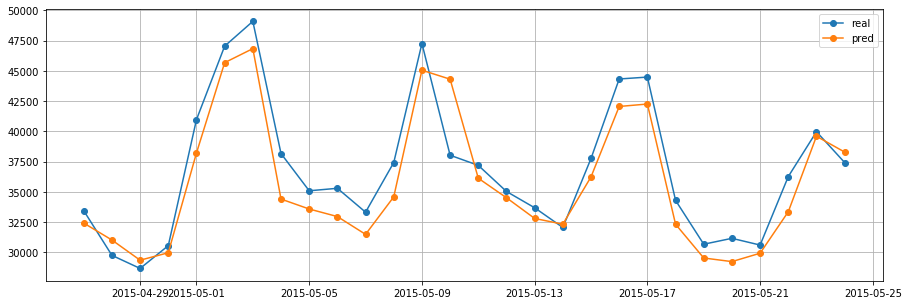

############################################### 2/13 ###############################################
##### Validation period: (Timestamp('2015-05-25 00:00:00'), Timestamp('2015-06-21 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1573.85it/s]


[0]	eval-rmse:5155.17
Will train until eval-rmse hasn't improved in 250 rounds.
[25]	eval-rmse:2747.8
[50]	eval-rmse:2573.7
[75]	eval-rmse:2404.06
[100]	eval-rmse:2477.28
[125]	eval-rmse:2327.21
[150]	eval-rmse:2277.31
[175]	eval-rmse:2272.5
[200]	eval-rmse:2271.79
[225]	eval-rmse:2224.31
[250]	eval-rmse:2180.09
[275]	eval-rmse:2173.25
[300]	eval-rmse:2177.31
[325]	eval-rmse:2186.01
[350]	eval-rmse:2228.02
[375]	eval-rmse:2223.44
[400]	eval-rmse:2176.24
[425]	eval-rmse:2164.13
[450]	eval-rmse:2141.36
[475]	eval-rmse:2150.9
[500]	eval-rmse:2162.85
[525]	eval-rmse:2162.2
[550]	eval-rmse:2197.87
[575]	eval-rmse:2185.7
[600]	eval-rmse:2179.24
[625]	eval-rmse:2184.06
[650]	eval-rmse:2168.28
[675]	eval-rmse:2149.62
Stopping. Best iteration:
[434]	eval-rmse:2135.49

RMSE: 2404.9025549402977
RMSSE: 0.4058213628291649


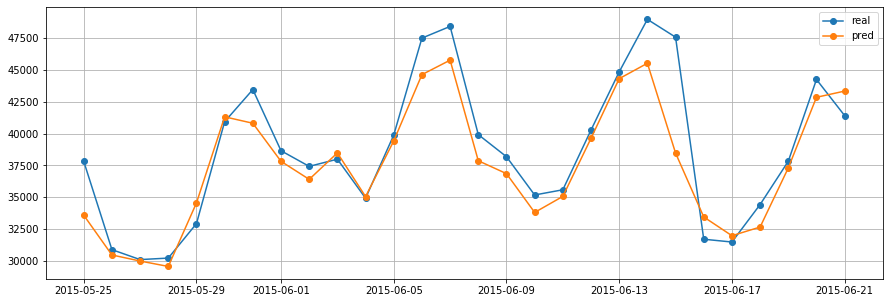

############################################### 3/13 ###############################################
##### Validation period: (Timestamp('2015-06-22 00:00:00'), Timestamp('2015-07-19 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1106.97it/s]


[0]	eval-rmse:5414.16
Will train until eval-rmse hasn't improved in 250 rounds.
[25]	eval-rmse:3160.8
[50]	eval-rmse:3001.7
[75]	eval-rmse:2879.63
[100]	eval-rmse:2735.95
[125]	eval-rmse:2684.99
[150]	eval-rmse:2693.07
[175]	eval-rmse:2649.46
[200]	eval-rmse:2596.93
[225]	eval-rmse:2587.66
[250]	eval-rmse:2567.31
[275]	eval-rmse:2505.97
[300]	eval-rmse:2484.45
[325]	eval-rmse:2449.88
[350]	eval-rmse:2392.89
[375]	eval-rmse:2368.96
[400]	eval-rmse:2348.43
[425]	eval-rmse:2343.46
[450]	eval-rmse:2307.17
[475]	eval-rmse:2290.98
[500]	eval-rmse:2277.97
[525]	eval-rmse:2283.11
[550]	eval-rmse:2288.88
[575]	eval-rmse:2265.81
[600]	eval-rmse:2273.67
[625]	eval-rmse:2261.11
[650]	eval-rmse:2268.54
[675]	eval-rmse:2254.98
[700]	eval-rmse:2260.13
[725]	eval-rmse:2247.62
[750]	eval-rmse:2228.77
[775]	eval-rmse:2225.45
[800]	eval-rmse:2210.81
[825]	eval-rmse:2195.02
[850]	eval-rmse:2198.63
[875]	eval-rmse:2202.45
[900]	eval-rmse:2196.81
[925]	eval-rmse:2178.71
[950]	eval-rmse:2166.45
[975]	eval-rm

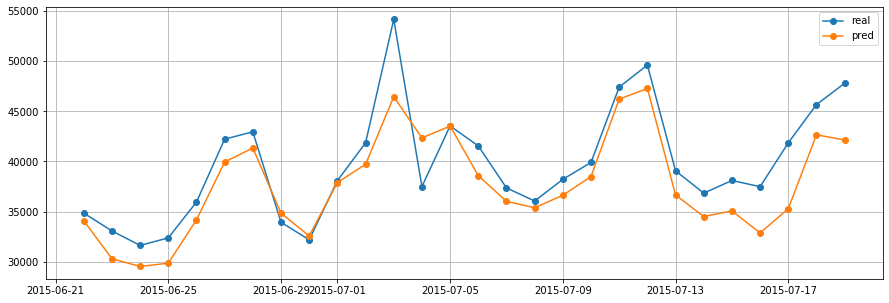

############################################### 4/13 ###############################################
##### Validation period: (Timestamp('2015-07-20 00:00:00'), Timestamp('2015-08-16 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1626.96it/s]


[0]	eval-rmse:5583.74
Will train until eval-rmse hasn't improved in 250 rounds.
[25]	eval-rmse:1908.46
[50]	eval-rmse:1905.14
[75]	eval-rmse:1805.49
[100]	eval-rmse:1754.36
[125]	eval-rmse:1664.11
[150]	eval-rmse:1552.95
[175]	eval-rmse:1443.65
[200]	eval-rmse:1402.65
[225]	eval-rmse:1371.23
[250]	eval-rmse:1335.16
[275]	eval-rmse:1321.01
[300]	eval-rmse:1252.45
[325]	eval-rmse:1197.39
[350]	eval-rmse:1174.42
[375]	eval-rmse:1157.02
[400]	eval-rmse:1135.59
[425]	eval-rmse:1135
[450]	eval-rmse:1111.43
[475]	eval-rmse:1076.92
[500]	eval-rmse:1057.44
[525]	eval-rmse:1018.81
[550]	eval-rmse:994.902
[575]	eval-rmse:1020.53
[600]	eval-rmse:1026.7
[625]	eval-rmse:1008.63
[650]	eval-rmse:992.915
[675]	eval-rmse:964.431
[700]	eval-rmse:965.801
[725]	eval-rmse:961.049
[750]	eval-rmse:984.335
[775]	eval-rmse:990.239
[800]	eval-rmse:958.198
[825]	eval-rmse:931.81
[850]	eval-rmse:975.758
[875]	eval-rmse:977.056
[900]	eval-rmse:998.155
[925]	eval-rmse:992.435
[950]	eval-rmse:984.128
[975]	eval-rmse:

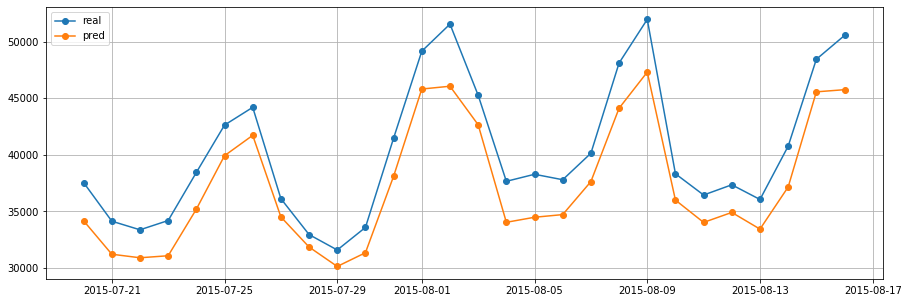

############################################### 5/13 ###############################################
##### Validation period: (Timestamp('2015-08-17 00:00:00'), Timestamp('2015-09-13 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1772.74it/s]


[0]	eval-rmse:4910.93
Will train until eval-rmse hasn't improved in 250 rounds.
[25]	eval-rmse:1729.7
[50]	eval-rmse:1659.58
[75]	eval-rmse:1705.97
[100]	eval-rmse:1810.19
[125]	eval-rmse:1792.19
[150]	eval-rmse:1808.25
[175]	eval-rmse:1857.35
[200]	eval-rmse:1841.37
[225]	eval-rmse:1842.34
[250]	eval-rmse:1889.48
[275]	eval-rmse:1894.56
Stopping. Best iteration:
[43]	eval-rmse:1633.92

RMSE: 1821.617498342574
RMSSE: 0.3073934510203843


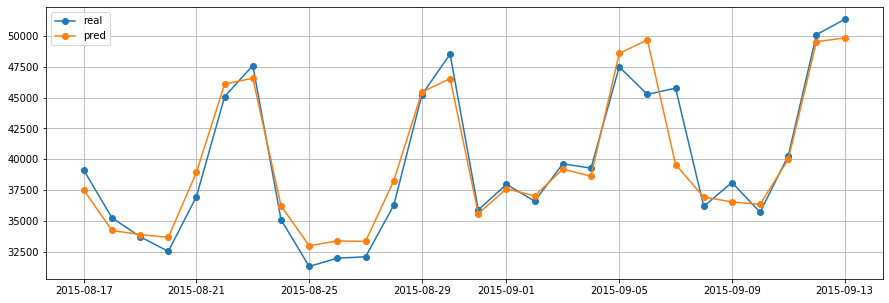

############################################### 6/13 ###############################################
##### Validation period: (Timestamp('2015-09-14 00:00:00'), Timestamp('2015-10-11 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 768.89it/s]


[0]	eval-rmse:5789.72
Will train until eval-rmse hasn't improved in 250 rounds.
[25]	eval-rmse:1929.22
[50]	eval-rmse:1819.05
[75]	eval-rmse:1860.79
[100]	eval-rmse:1813.33
[125]	eval-rmse:1712.78
[150]	eval-rmse:1730.8
[175]	eval-rmse:1727.56
[200]	eval-rmse:1751.54
[225]	eval-rmse:1720.09
[250]	eval-rmse:1697.91
[275]	eval-rmse:1721.58
[300]	eval-rmse:1793.22
[325]	eval-rmse:1793.17
[350]	eval-rmse:1773
[375]	eval-rmse:1858.74
Stopping. Best iteration:
[138]	eval-rmse:1651.14

RMSE: 1847.7510513847408
RMSSE: 0.3118034235115166


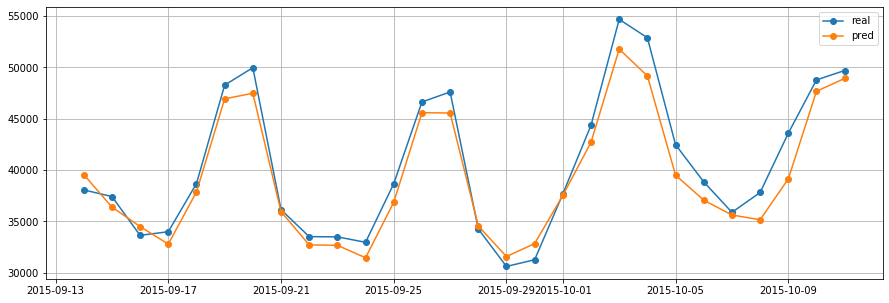

############################################### 7/13 ###############################################
##### Validation period: (Timestamp('2015-10-12 00:00:00'), Timestamp('2015-11-08 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1622.55it/s]


[0]	eval-rmse:4618.95
Will train until eval-rmse hasn't improved in 250 rounds.
[25]	eval-rmse:1892.99
[50]	eval-rmse:1652.27
[75]	eval-rmse:1605.78
[100]	eval-rmse:1469.13
[125]	eval-rmse:1448.35
[150]	eval-rmse:1429.7
[175]	eval-rmse:1413.36
[200]	eval-rmse:1416.52
[225]	eval-rmse:1385.73
[250]	eval-rmse:1331.68
[275]	eval-rmse:1357.17
[300]	eval-rmse:1388.2
[325]	eval-rmse:1370.49
[350]	eval-rmse:1341.31
[375]	eval-rmse:1350.15
[400]	eval-rmse:1357.96
[425]	eval-rmse:1335.19
[450]	eval-rmse:1336.26
[475]	eval-rmse:1353.63
Stopping. Best iteration:
[246]	eval-rmse:1318.9

RMSE: 1460.8527946282754
RMSSE: 0.24651529883860865


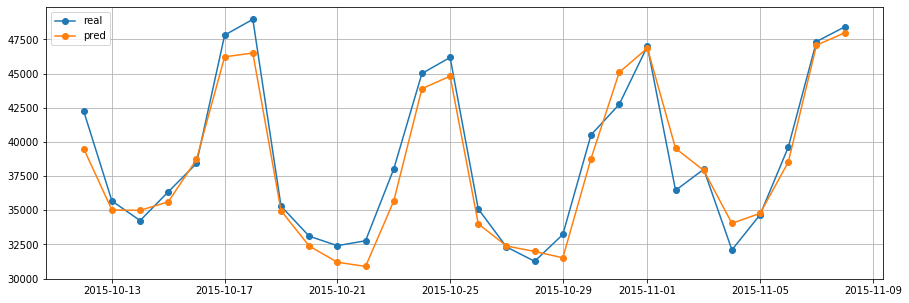

############################################### 8/13 ###############################################
##### Validation period: (Timestamp('2015-11-09 00:00:00'), Timestamp('2015-12-06 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1738.93it/s]


[0]	eval-rmse:5931.91
Will train until eval-rmse hasn't improved in 250 rounds.
[25]	eval-rmse:2542.08
[50]	eval-rmse:2515.57
[75]	eval-rmse:2478.22
[100]	eval-rmse:2427.04
[125]	eval-rmse:2341.1
[150]	eval-rmse:2266.89
[175]	eval-rmse:2299.6
[200]	eval-rmse:2241.4
[225]	eval-rmse:2326.05
[250]	eval-rmse:2289.91
[275]	eval-rmse:2303.96
[300]	eval-rmse:2307.52
[325]	eval-rmse:2329.38
[350]	eval-rmse:2349.08
[375]	eval-rmse:2300.46
[400]	eval-rmse:2309.54
Stopping. Best iteration:
[166]	eval-rmse:2209.88

RMSE: 2903.6925746835154
RMSSE: 0.48999094598418963


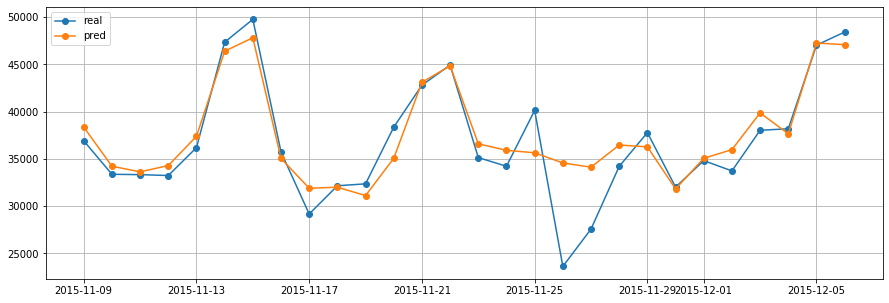

############################################### 9/13 ###############################################
##### Validation period: (Timestamp('2015-12-07 00:00:00'), Timestamp('2016-01-03 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1161.21it/s]


[0]	eval-rmse:8590.2
Will train until eval-rmse hasn't improved in 250 rounds.
[25]	eval-rmse:5694.13
[50]	eval-rmse:4588.9
[75]	eval-rmse:3921.96
[100]	eval-rmse:3588.72
[125]	eval-rmse:3453.93
[150]	eval-rmse:3308.1
[175]	eval-rmse:3239.37
[200]	eval-rmse:3195.72
[225]	eval-rmse:3137.06
[250]	eval-rmse:3103.41
[275]	eval-rmse:3047.65
[300]	eval-rmse:3005.73
[325]	eval-rmse:3003.15
[350]	eval-rmse:2976.88
[375]	eval-rmse:2957.98
[400]	eval-rmse:2953.99
[425]	eval-rmse:2933.98
[450]	eval-rmse:2917.99
[475]	eval-rmse:2916.15
[500]	eval-rmse:2930.11
[525]	eval-rmse:2949.31
[550]	eval-rmse:2980.94
[575]	eval-rmse:2996.28
[600]	eval-rmse:3001.65
[625]	eval-rmse:2991.48
[650]	eval-rmse:3005.76
[675]	eval-rmse:2999.64
[700]	eval-rmse:3001.98
Stopping. Best iteration:
[459]	eval-rmse:2901.93

RMSE: 6285.507563241569
RMSSE: 1.0606638677096176


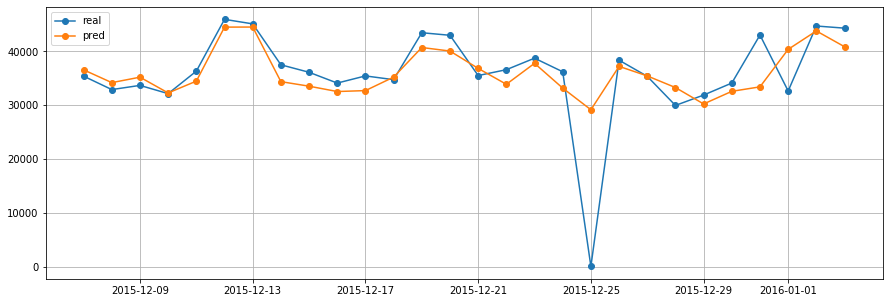

############################################## 10/13 ###############################################
##### Validation period: (Timestamp('2016-01-04 00:00:00'), Timestamp('2016-01-31 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1663.09it/s]


[0]	eval-rmse:5848.19
Will train until eval-rmse hasn't improved in 250 rounds.
[25]	eval-rmse:2334.29
[50]	eval-rmse:2400.28
[75]	eval-rmse:2218.81
[100]	eval-rmse:2119.62
[125]	eval-rmse:2044.43
[150]	eval-rmse:2034.97
[175]	eval-rmse:1977.7
[200]	eval-rmse:1944.99
[225]	eval-rmse:1947.5
[250]	eval-rmse:1927.24
[275]	eval-rmse:1923.7
[300]	eval-rmse:1917.64
[325]	eval-rmse:1909.16
[350]	eval-rmse:1890.37
[375]	eval-rmse:1901.28
[400]	eval-rmse:1933.9
[425]	eval-rmse:1936.86
[450]	eval-rmse:1925.62
[475]	eval-rmse:1929.27
[500]	eval-rmse:1920.07
[525]	eval-rmse:1926.29
[550]	eval-rmse:1911.76
[575]	eval-rmse:1921.17
[600]	eval-rmse:1913.4
Stopping. Best iteration:
[362]	eval-rmse:1848.4

RMSE: 2578.658093098988
RMSSE: 0.4351421804855066


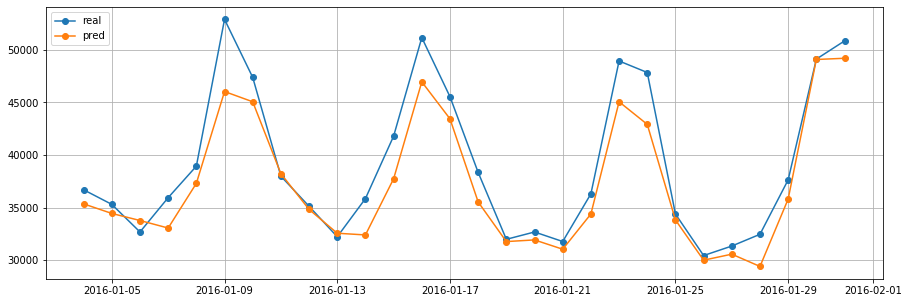

############################################## 11/13 ###############################################
##### Validation period: (Timestamp('2016-02-01 00:00:00'), Timestamp('2016-02-28 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 637.43it/s]


[0]	eval-rmse:5679.86
Will train until eval-rmse hasn't improved in 250 rounds.
[25]	eval-rmse:3416.2
[50]	eval-rmse:3131.73
[75]	eval-rmse:2920.19
[100]	eval-rmse:2716.19
[125]	eval-rmse:2755.99
[150]	eval-rmse:2781.91
[175]	eval-rmse:2808.95
[200]	eval-rmse:2834.16
[225]	eval-rmse:2765.75
[250]	eval-rmse:2827.62
[275]	eval-rmse:2840.36
[300]	eval-rmse:2887.38
[325]	eval-rmse:2925.16
[350]	eval-rmse:2933.74
Stopping. Best iteration:
[100]	eval-rmse:2716.19

RMSE: 3161.6606602291854
RMSSE: 0.5335224228947679


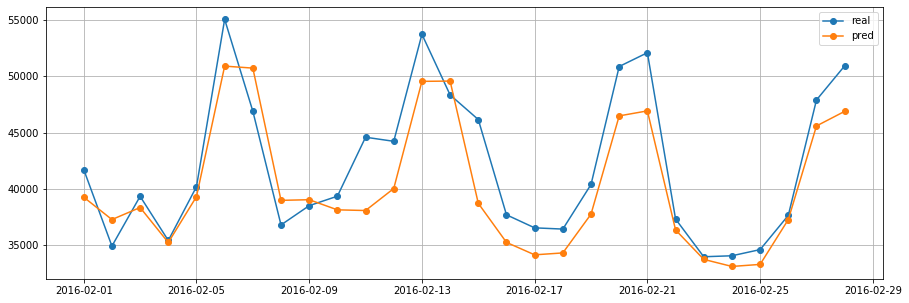

############################################## 12/13 ###############################################
##### Validation period: (Timestamp('2016-02-29 00:00:00'), Timestamp('2016-03-27 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1569.14it/s]


[0]	eval-rmse:5536.47
Will train until eval-rmse hasn't improved in 250 rounds.
[25]	eval-rmse:2261.37
[50]	eval-rmse:2151.74
[75]	eval-rmse:2208.83
[100]	eval-rmse:2165.63
[125]	eval-rmse:2196.3
[150]	eval-rmse:2159.07
[175]	eval-rmse:2172.36
[200]	eval-rmse:2176.2
[225]	eval-rmse:2166.68
[250]	eval-rmse:2167.07
[275]	eval-rmse:2170.46
[300]	eval-rmse:2204.02
Stopping. Best iteration:
[60]	eval-rmse:2133.69

RMSE: 2271.2975471261498
RMSSE: 0.3832758479431014


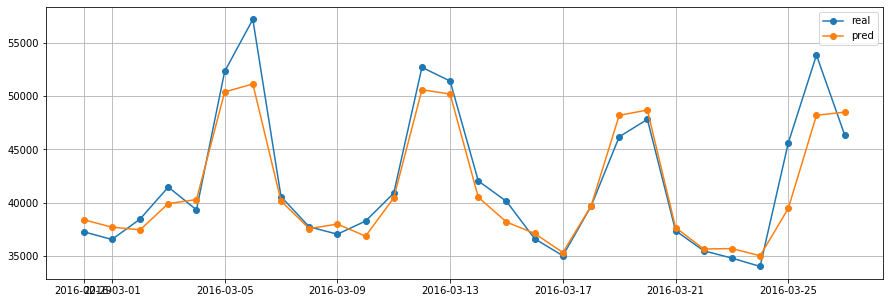

############################################## 13/13 ###############################################
##### Validation period: (Timestamp('2016-03-28 00:00:00'), Timestamp('2016-04-24 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1512.55it/s]


[0]	eval-rmse:5904.22
Will train until eval-rmse hasn't improved in 250 rounds.
[25]	eval-rmse:1707.81
[50]	eval-rmse:1541.91
[75]	eval-rmse:1465.15
[100]	eval-rmse:1428.57
[125]	eval-rmse:1398.12
[150]	eval-rmse:1364.11
[175]	eval-rmse:1350.95
[200]	eval-rmse:1345.14
[225]	eval-rmse:1358.77
[250]	eval-rmse:1342.96
[275]	eval-rmse:1352.55
[300]	eval-rmse:1293.68
[325]	eval-rmse:1323.74
[350]	eval-rmse:1334.62
[375]	eval-rmse:1353.26
[400]	eval-rmse:1346.69
[425]	eval-rmse:1358.73
[450]	eval-rmse:1377.88
[475]	eval-rmse:1383.53
[500]	eval-rmse:1400.41
[525]	eval-rmse:1428.6
Stopping. Best iteration:
[297]	eval-rmse:1276.57

RMSE: 2381.542518450123
RMSSE: 0.4018794144018961


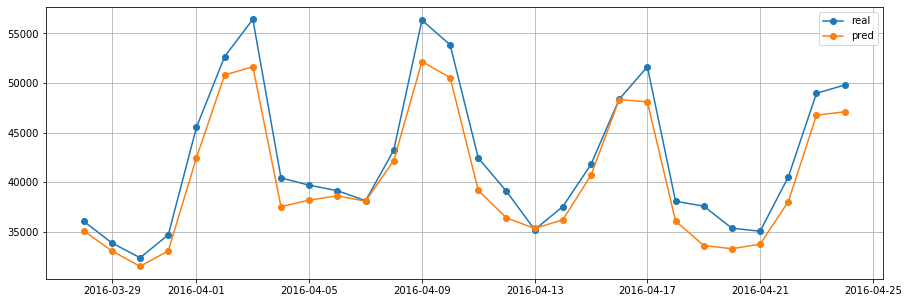

In [13]:
models = list()
errors = list()
best_iterations = list()

for i,valid_period in enumerate(valid_periods):
    print(f" {i+1}/{len(valid_periods)} ".center(100, "#"))
    print(f" Validation period: {valid_period} ".center(100, "#"))
    print("#"*100)
    
    valid_start = valid_period[0]
    valid_end = valid_period[1]
    
    train_start = valid_start - pd.DateOffset(days=train_history)
        
    _train_data = data.query("@train_start <= ds <= @valid_end").reset_index(drop=True)
    _valid_index = _train_data.query("@valid_start <= ds <= @valid_end").index

    model_kwargs["trend_models"] = compute_trend_models(_train_data,
                                                        _valid_index)

    _fcaster = XGBoostForecaster(**model_kwargs)
    _fcaster.prepare_features(train_data=_train_data, valid_index=_valid_index);

    _fcaster.train_features = reduce_mem_usage(_fcaster.train_features)
    _fcaster.valid_features = reduce_mem_usage(_fcaster.valid_features)
    
    _fcaster.fit(fit_kwargs={"verbose_eval":25})

    #lgb.plot_importance(_fcaster.model.model, importance_type="split", figsize=(10,8))
    #lgb.plot_importance(_fcaster.model.model, importance_type="gain", figsize=(10,8))
    
    models.append(_fcaster)
    errors.append(_fcaster.model.model.best_score)
    best_iterations.append(_fcaster.best_iteration)

    predictions = _fcaster.predict(_fcaster.valid_features.loc[:, data.columns.drop("y")])
    predictions = pd.merge(predictions,
                           _fcaster.valid_features.loc[:, ["ds","y_raw"]], 
                           how="inner", 
                           on=["ds"]).rename({"y_raw":"y"}, axis=1)
    
    error = np.sqrt(predictions.eval("(y_pred-y)**2").mean())

    print(f"RMSE: {error}")
    print(f"RMSSE: {error/scale_factor}")
    plt.figure(figsize=(15,5))
    plt.plot_date(predictions.ds, predictions.y, "o-", label="real")
    plt.plot_date(predictions.ds, predictions.y_pred, "o-", label="pred")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

############################################### 1/13 ###############################################
##### Validation period: (Timestamp('2015-04-27 00:00:00'), Timestamp('2015-05-24 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1047.01it/s]


Training until validation scores don't improve for 250 rounds
[25]	valid_0's rmse: 2452.63
[50]	valid_0's rmse: 2179.41
[75]	valid_0's rmse: 1964.17
[100]	valid_0's rmse: 1899.21
[125]	valid_0's rmse: 1868.27
[150]	valid_0's rmse: 1801.45
[175]	valid_0's rmse: 1741.97
[200]	valid_0's rmse: 1702.92
[225]	valid_0's rmse: 1754.14
[250]	valid_0's rmse: 1730.65
[275]	valid_0's rmse: 1755.67
[300]	valid_0's rmse: 1757.98
[325]	valid_0's rmse: 1758.29
[350]	valid_0's rmse: 1782.62
[375]	valid_0's rmse: 1758.41
[400]	valid_0's rmse: 1749.88
[425]	valid_0's rmse: 1738.92
Early stopping, best iteration is:
[198]	valid_0's rmse: 1699.78
RMSE: 1699.7831532108662
RMSSE: 0.2868342063727458


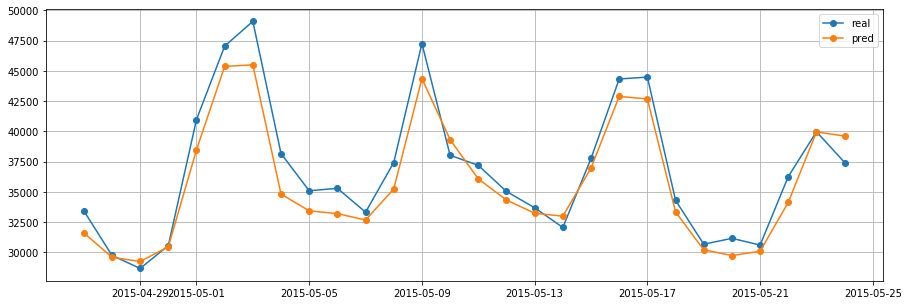

############################################### 2/13 ###############################################
##### Validation period: (Timestamp('2015-05-25 00:00:00'), Timestamp('2015-06-21 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 82.57it/s]


Training until validation scores don't improve for 250 rounds
[25]	valid_0's rmse: 2973.09
[50]	valid_0's rmse: 2643.83
[75]	valid_0's rmse: 2512.16
[100]	valid_0's rmse: 2342.22
[125]	valid_0's rmse: 2297.75
[150]	valid_0's rmse: 2246.27
[175]	valid_0's rmse: 2246.28
[200]	valid_0's rmse: 2240.05
[225]	valid_0's rmse: 2225.77
[250]	valid_0's rmse: 2222.58
[275]	valid_0's rmse: 2217.48
[300]	valid_0's rmse: 2216.11
[325]	valid_0's rmse: 2253.2
[350]	valid_0's rmse: 2260.34
[375]	valid_0's rmse: 2249.09
[400]	valid_0's rmse: 2254.24
[425]	valid_0's rmse: 2247.23
[450]	valid_0's rmse: 2241.67
[475]	valid_0's rmse: 2237.22
[500]	valid_0's rmse: 2226.55
Early stopping, best iteration is:
[255]	valid_0's rmse: 2209.51
RMSE: 2209.5074050763506
RMSSE: 0.37284891417626537


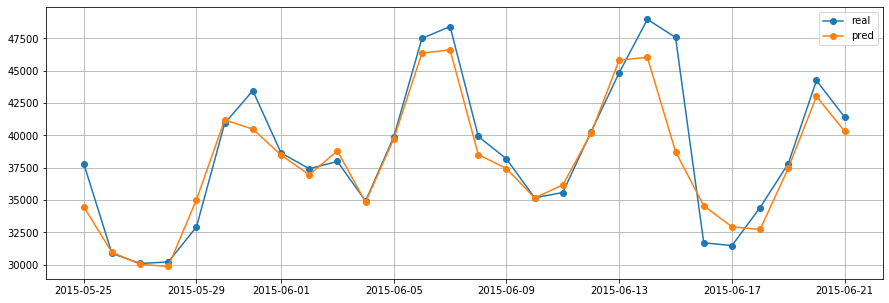

############################################### 3/13 ###############################################
##### Validation period: (Timestamp('2015-06-22 00:00:00'), Timestamp('2015-07-19 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1616.30it/s]


Training until validation scores don't improve for 250 rounds
[25]	valid_0's rmse: 3587.44
[50]	valid_0's rmse: 3175.93
[75]	valid_0's rmse: 2984.52
[100]	valid_0's rmse: 2879.98
[125]	valid_0's rmse: 2761.24
[150]	valid_0's rmse: 2701.24
[175]	valid_0's rmse: 2656.27
[200]	valid_0's rmse: 2614.29
[225]	valid_0's rmse: 2603.73
[250]	valid_0's rmse: 2544.29
[275]	valid_0's rmse: 2499.28
[300]	valid_0's rmse: 2451.14
[325]	valid_0's rmse: 2441.29
[350]	valid_0's rmse: 2415.91
[375]	valid_0's rmse: 2406.11
[400]	valid_0's rmse: 2386.96
[425]	valid_0's rmse: 2380.88
[450]	valid_0's rmse: 2359.51
[475]	valid_0's rmse: 2339.36
[500]	valid_0's rmse: 2325.43
[525]	valid_0's rmse: 2325.06
[550]	valid_0's rmse: 2315.87
[575]	valid_0's rmse: 2306.7
[600]	valid_0's rmse: 2295.36
[625]	valid_0's rmse: 2283.19
[650]	valid_0's rmse: 2275.78
[675]	valid_0's rmse: 2266.06
[700]	valid_0's rmse: 2252.16
[725]	valid_0's rmse: 2237.75
[750]	valid_0's rmse: 2234.4
[775]	valid_0's rmse: 2226.71
[800]	valid_0

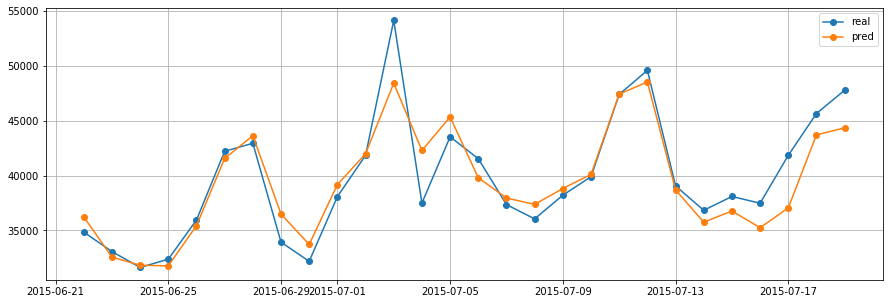

############################################### 4/13 ###############################################
##### Validation period: (Timestamp('2015-07-20 00:00:00'), Timestamp('2015-08-16 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1930.19it/s]


Training until validation scores don't improve for 250 rounds
[25]	valid_0's rmse: 2300.85
[50]	valid_0's rmse: 1932.55
[75]	valid_0's rmse: 1787.19
[100]	valid_0's rmse: 1538
[125]	valid_0's rmse: 1415.6
[150]	valid_0's rmse: 1339.32
[175]	valid_0's rmse: 1365.23
[200]	valid_0's rmse: 1317.97
[225]	valid_0's rmse: 1297.21
[250]	valid_0's rmse: 1288.86
[275]	valid_0's rmse: 1289.25
[300]	valid_0's rmse: 1284.45
[325]	valid_0's rmse: 1269.96
[350]	valid_0's rmse: 1264.84
[375]	valid_0's rmse: 1231.73
[400]	valid_0's rmse: 1243.07
[425]	valid_0's rmse: 1248.69
[450]	valid_0's rmse: 1240.91
[475]	valid_0's rmse: 1252.74
[500]	valid_0's rmse: 1256.88
[525]	valid_0's rmse: 1240.09
[550]	valid_0's rmse: 1219.68
[575]	valid_0's rmse: 1195.46
[600]	valid_0's rmse: 1196.62
[625]	valid_0's rmse: 1181.88
[650]	valid_0's rmse: 1170.2
[675]	valid_0's rmse: 1163.56
[700]	valid_0's rmse: 1169.95
[725]	valid_0's rmse: 1150.49
[750]	valid_0's rmse: 1153.19
[775]	valid_0's rmse: 1147.43
[800]	valid_0's 

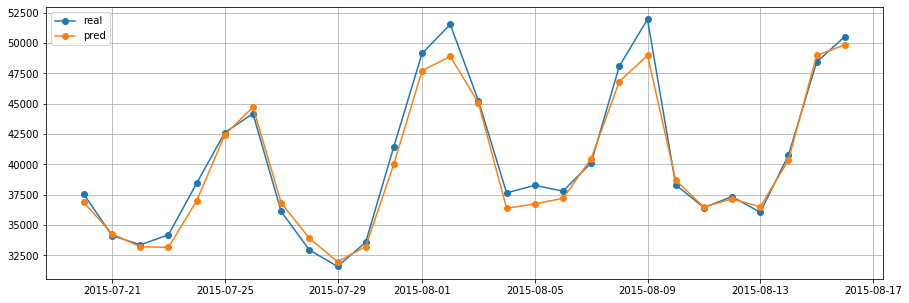

############################################### 5/13 ###############################################
##### Validation period: (Timestamp('2015-08-17 00:00:00'), Timestamp('2015-09-13 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1261.82it/s]


Training until validation scores don't improve for 250 rounds
[25]	valid_0's rmse: 2013.12
[50]	valid_0's rmse: 1750.09
[75]	valid_0's rmse: 1704.71
[100]	valid_0's rmse: 1721.25
[125]	valid_0's rmse: 1715.52
[150]	valid_0's rmse: 1737.92
[175]	valid_0's rmse: 1752.78
[200]	valid_0's rmse: 1747.61
[225]	valid_0's rmse: 1747.79
[250]	valid_0's rmse: 1767.5
[275]	valid_0's rmse: 1774.19
[300]	valid_0's rmse: 1803.93
[325]	valid_0's rmse: 1815.95
Early stopping, best iteration is:
[85]	valid_0's rmse: 1693.26
RMSE: 1693.2606238837475
RMSSE: 0.2857335456681418


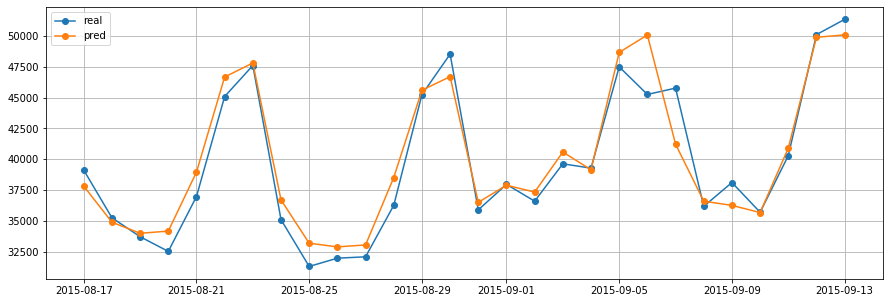

############################################### 6/13 ###############################################
##### Validation period: (Timestamp('2015-09-14 00:00:00'), Timestamp('2015-10-11 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1972.86it/s]


Training until validation scores don't improve for 250 rounds
[25]	valid_0's rmse: 2353.76
[50]	valid_0's rmse: 1895.03
[75]	valid_0's rmse: 1836.65
[100]	valid_0's rmse: 1787.25
[125]	valid_0's rmse: 1802.2
[150]	valid_0's rmse: 1802.07
[175]	valid_0's rmse: 1845.24
[200]	valid_0's rmse: 1875.13
[225]	valid_0's rmse: 1836.84
[250]	valid_0's rmse: 1842.98
[275]	valid_0's rmse: 1847.14
[300]	valid_0's rmse: 1863.6
[325]	valid_0's rmse: 1858.77
[350]	valid_0's rmse: 1890.5
Early stopping, best iteration is:
[114]	valid_0's rmse: 1772.36
RMSE: 1772.3600052392792
RMSSE: 0.29908137079091174


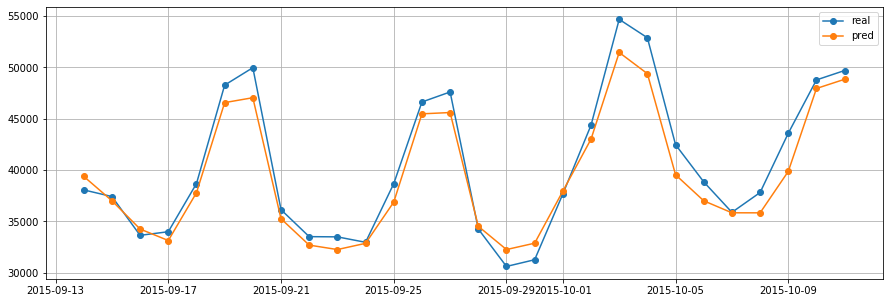

############################################### 7/13 ###############################################
##### Validation period: (Timestamp('2015-10-12 00:00:00'), Timestamp('2015-11-08 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1698.10it/s]


Training until validation scores don't improve for 250 rounds
[25]	valid_0's rmse: 1646.25
[50]	valid_0's rmse: 1548.62
[75]	valid_0's rmse: 1461.07
[100]	valid_0's rmse: 1395.35
[125]	valid_0's rmse: 1380.71
[150]	valid_0's rmse: 1301.66
[175]	valid_0's rmse: 1270.48
[200]	valid_0's rmse: 1272.11
[225]	valid_0's rmse: 1279.28
[250]	valid_0's rmse: 1281.49
[275]	valid_0's rmse: 1279.95
[300]	valid_0's rmse: 1279.15
[325]	valid_0's rmse: 1259.79
[350]	valid_0's rmse: 1254.25
[375]	valid_0's rmse: 1282.47
[400]	valid_0's rmse: 1308.11
[425]	valid_0's rmse: 1308.68
[450]	valid_0's rmse: 1314.82
[475]	valid_0's rmse: 1309.69
[500]	valid_0's rmse: 1302.74
[525]	valid_0's rmse: 1305.04
[550]	valid_0's rmse: 1307.75
[575]	valid_0's rmse: 1302.67
Early stopping, best iteration is:
[341]	valid_0's rmse: 1252.52
RMSE: 1252.521474101433
RMSSE: 0.2113599033559415


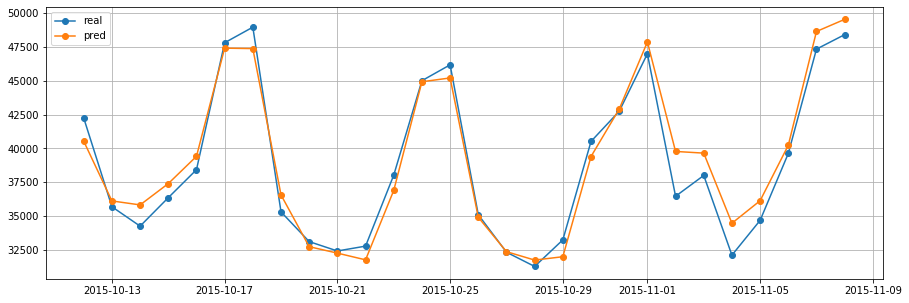

############################################### 8/13 ###############################################
##### Validation period: (Timestamp('2015-11-09 00:00:00'), Timestamp('2015-12-06 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 700.57it/s]


Training until validation scores don't improve for 250 rounds
[25]	valid_0's rmse: 3291.01
[50]	valid_0's rmse: 2650.49
[75]	valid_0's rmse: 2458.66
[100]	valid_0's rmse: 2394.61
[125]	valid_0's rmse: 2286.26
[150]	valid_0's rmse: 2268.93
[175]	valid_0's rmse: 2243.72
[200]	valid_0's rmse: 2277.97
[225]	valid_0's rmse: 2254.6
[250]	valid_0's rmse: 2245.93
[275]	valid_0's rmse: 2213.05
[300]	valid_0's rmse: 2153.23
[325]	valid_0's rmse: 2142.41
[350]	valid_0's rmse: 2150.18
[375]	valid_0's rmse: 2101.63
[400]	valid_0's rmse: 2076.19
[425]	valid_0's rmse: 2060.76
[450]	valid_0's rmse: 2078.31
[475]	valid_0's rmse: 2087.85
[500]	valid_0's rmse: 2074.26
[525]	valid_0's rmse: 2047.28
[550]	valid_0's rmse: 2056.04
[575]	valid_0's rmse: 2056.91
[600]	valid_0's rmse: 2045.68
[625]	valid_0's rmse: 2043.58
[650]	valid_0's rmse: 2037.42
[675]	valid_0's rmse: 2032.07
[700]	valid_0's rmse: 2024.43
[725]	valid_0's rmse: 2039.13
[750]	valid_0's rmse: 2018.49
[775]	valid_0's rmse: 2024.03
[800]	valid_

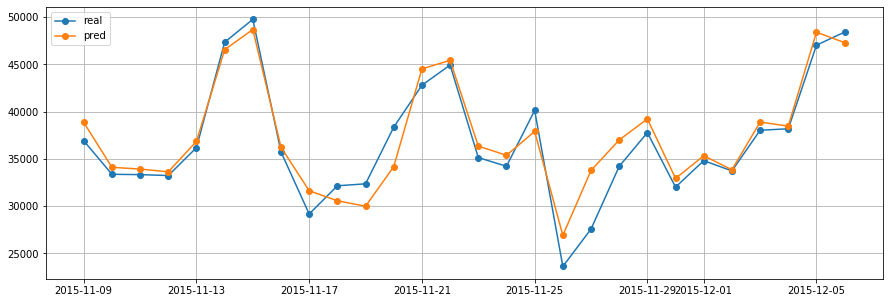

############################################### 9/13 ###############################################
##### Validation period: (Timestamp('2015-12-07 00:00:00'), Timestamp('2016-01-03 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1515.83it/s]


Training until validation scores don't improve for 250 rounds
[25]	valid_0's rmse: 7506.93
[50]	valid_0's rmse: 6284.25
[75]	valid_0's rmse: 5547.96
[100]	valid_0's rmse: 5132
[125]	valid_0's rmse: 4818.73
[150]	valid_0's rmse: 4558.19
[175]	valid_0's rmse: 4324.12
[200]	valid_0's rmse: 4141.48
[225]	valid_0's rmse: 4020.57
[250]	valid_0's rmse: 3910.94
[275]	valid_0's rmse: 3840.83
[300]	valid_0's rmse: 3777.3
[325]	valid_0's rmse: 3724.26
[350]	valid_0's rmse: 3643.99
[375]	valid_0's rmse: 3626.51
[400]	valid_0's rmse: 3574.25
[425]	valid_0's rmse: 3576.63
[450]	valid_0's rmse: 3559.22
[475]	valid_0's rmse: 3530.35
[500]	valid_0's rmse: 3504.77
[525]	valid_0's rmse: 3501.84
[550]	valid_0's rmse: 3496.16
[575]	valid_0's rmse: 3502
[600]	valid_0's rmse: 3503.7
[625]	valid_0's rmse: 3511.01
[650]	valid_0's rmse: 3521.46
[675]	valid_0's rmse: 3522.88
[700]	valid_0's rmse: 3520.16
[725]	valid_0's rmse: 3516.06
[750]	valid_0's rmse: 3520.77
[775]	valid_0's rmse: 3531.49
Early stopping, bes

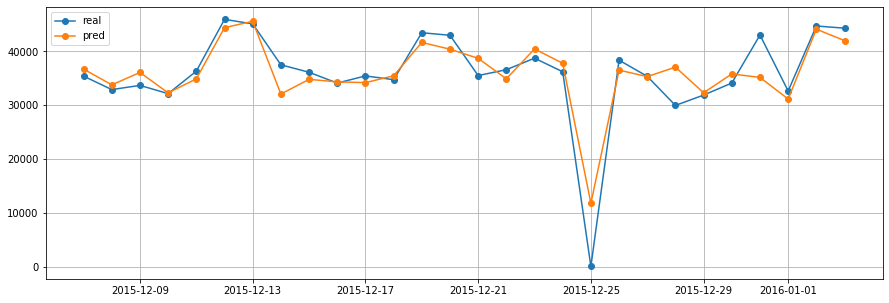

############################################## 10/13 ###############################################
##### Validation period: (Timestamp('2016-01-04 00:00:00'), Timestamp('2016-01-31 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1390.22it/s]


Training until validation scores don't improve for 250 rounds
[25]	valid_0's rmse: 2493.16
[50]	valid_0's rmse: 2386.04
[75]	valid_0's rmse: 2333.86
[100]	valid_0's rmse: 2256.19
[125]	valid_0's rmse: 2200.75
[150]	valid_0's rmse: 2199.25
[175]	valid_0's rmse: 2143.61
[200]	valid_0's rmse: 2188.1
[225]	valid_0's rmse: 2199.36
[250]	valid_0's rmse: 2208.37
[275]	valid_0's rmse: 2214.71
[300]	valid_0's rmse: 2157.03
[325]	valid_0's rmse: 2173.6
[350]	valid_0's rmse: 2189.44
[375]	valid_0's rmse: 2198.28
[400]	valid_0's rmse: 2199.48
[425]	valid_0's rmse: 2188.5
Early stopping, best iteration is:
[177]	valid_0's rmse: 2129.36
RMSE: 2129.357443857535
RMSSE: 0.35932380629789984


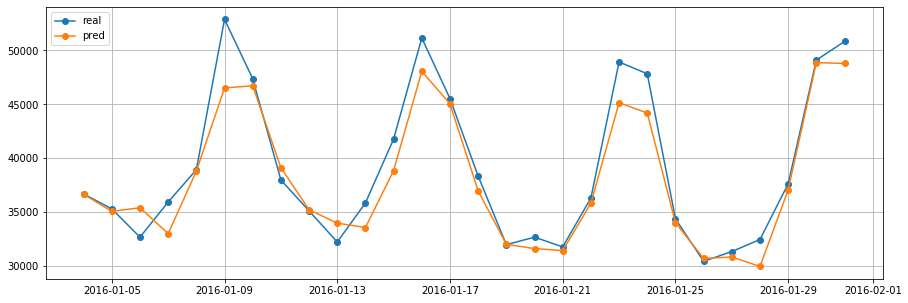

############################################## 11/13 ###############################################
##### Validation period: (Timestamp('2016-02-01 00:00:00'), Timestamp('2016-02-28 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1380.61it/s]


Training until validation scores don't improve for 250 rounds
[25]	valid_0's rmse: 3373.05
[50]	valid_0's rmse: 3102.84
[75]	valid_0's rmse: 2883.23
[100]	valid_0's rmse: 2847.18
[125]	valid_0's rmse: 2804.76
[150]	valid_0's rmse: 2814.88
[175]	valid_0's rmse: 2829.53
[200]	valid_0's rmse: 2845.41
[225]	valid_0's rmse: 2832.57
[250]	valid_0's rmse: 2828.44
[275]	valid_0's rmse: 2840.12
[300]	valid_0's rmse: 2863.88
[325]	valid_0's rmse: 2887.44
[350]	valid_0's rmse: 2896.33
[375]	valid_0's rmse: 2906.3
Early stopping, best iteration is:
[142]	valid_0's rmse: 2785.83
RMSE: 2785.8265448864836
RMSSE: 0.4701013447422458


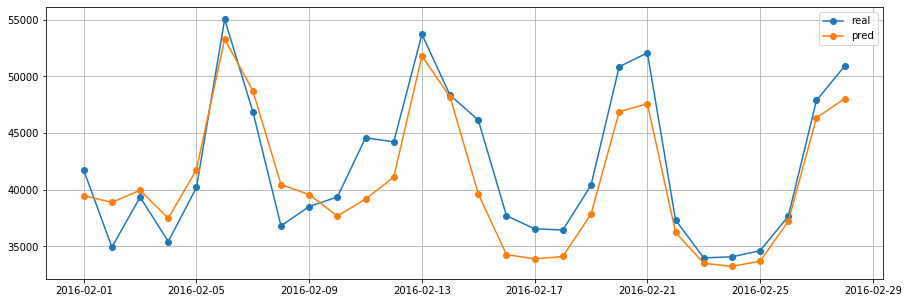

############################################## 12/13 ###############################################
##### Validation period: (Timestamp('2016-02-29 00:00:00'), Timestamp('2016-03-27 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 84.32it/s]


Training until validation scores don't improve for 250 rounds
[25]	valid_0's rmse: 2734.19
[50]	valid_0's rmse: 2358.99
[75]	valid_0's rmse: 2224.17
[100]	valid_0's rmse: 2144.95
[125]	valid_0's rmse: 2150.15
[150]	valid_0's rmse: 2136.77
[175]	valid_0's rmse: 2120.2
[200]	valid_0's rmse: 2131.45
[225]	valid_0's rmse: 2139.91
[250]	valid_0's rmse: 2165.8
[275]	valid_0's rmse: 2161.15
[300]	valid_0's rmse: 2138.86
[325]	valid_0's rmse: 2124.13
[350]	valid_0's rmse: 2121.05
[375]	valid_0's rmse: 2130.49
[400]	valid_0's rmse: 2139.69
[425]	valid_0's rmse: 2150.58
[450]	valid_0's rmse: 2138.62
[475]	valid_0's rmse: 2144.58
[500]	valid_0's rmse: 2117.91
[525]	valid_0's rmse: 2109.75
[550]	valid_0's rmse: 2108.13
[575]	valid_0's rmse: 2104.75
[600]	valid_0's rmse: 2113.37
[625]	valid_0's rmse: 2120.11
[650]	valid_0's rmse: 2132.41
[675]	valid_0's rmse: 2125.15
[700]	valid_0's rmse: 2136.96
[725]	valid_0's rmse: 2136.72
[750]	valid_0's rmse: 2135.97
[775]	valid_0's rmse: 2135.04
[800]	valid_0

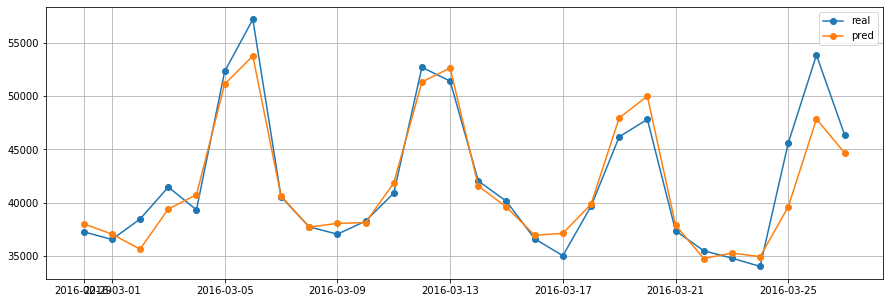

############################################## 13/13 ###############################################
##### Validation period: (Timestamp('2016-03-28 00:00:00'), Timestamp('2016-04-24 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1690.57it/s]


Training until validation scores don't improve for 250 rounds
[25]	valid_0's rmse: 2346.65
[50]	valid_0's rmse: 1665.38
[75]	valid_0's rmse: 1495.4
[100]	valid_0's rmse: 1426.16
[125]	valid_0's rmse: 1344.41
[150]	valid_0's rmse: 1314.9
[175]	valid_0's rmse: 1291.63
[200]	valid_0's rmse: 1281.85
[225]	valid_0's rmse: 1278.64
[250]	valid_0's rmse: 1299.08
[275]	valid_0's rmse: 1292.76
[300]	valid_0's rmse: 1323.19
[325]	valid_0's rmse: 1305.84
[350]	valid_0's rmse: 1285.2
[375]	valid_0's rmse: 1278.2
[400]	valid_0's rmse: 1270.04
[425]	valid_0's rmse: 1264.12
[450]	valid_0's rmse: 1270.66
[475]	valid_0's rmse: 1270.99
[500]	valid_0's rmse: 1276.26
[525]	valid_0's rmse: 1275.46
[550]	valid_0's rmse: 1276.96
[575]	valid_0's rmse: 1275.96
[600]	valid_0's rmse: 1277.57
[625]	valid_0's rmse: 1278.43
[650]	valid_0's rmse: 1280.58
Early stopping, best iteration is:
[419]	valid_0's rmse: 1260.2
RMSE: 1260.1965387751015
RMSSE: 0.2126550515519762


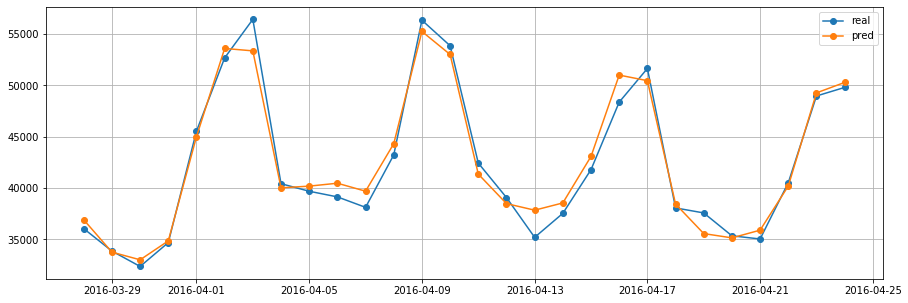

In [22]:
models = list()
errors = list()
best_iterations = list()

for i,valid_period in enumerate(valid_periods):
    print(f" {i+1}/{len(valid_periods)} ".center(100, "#"))
    print(f" Validation period: {valid_period} ".center(100, "#"))
    print("#"*100)
    
    valid_start = valid_period[0]
    valid_end = valid_period[1]
    
    train_start = valid_start - pd.DateOffset(days=train_history)
        
    _train_data = data.query("@train_start <= ds <= @valid_end").reset_index(drop=True)
    _valid_index = _train_data.query("@valid_start <= ds <= @valid_end").index

    model_kwargs["trend_models"] = compute_trend_models(_train_data,
                                                        _valid_index)

    _fcaster = LightGBMForecaster(**model_kwargs)
    _fcaster.prepare_features(train_data=_train_data, valid_index=_valid_index);

    _fcaster.train_features = reduce_mem_usage(_fcaster.train_features)
    _fcaster.valid_features = reduce_mem_usage(_fcaster.valid_features)
    
    _fcaster.fit(fit_kwargs={"verbose_eval":25})

    #lgb.plot_importance(_fcaster.model.model, importance_type="split", figsize=(10,8))
    #lgb.plot_importance(_fcaster.model.model, importance_type="gain", figsize=(10,8))
    
    models.append(_fcaster)
    errors.append(_fcaster.model.model.best_score["valid_0"]["rmse"])
    best_iterations.append(_fcaster.best_iteration)

    predictions = _fcaster.predict(_fcaster.valid_features.loc[:, data.columns.drop("y")])
    predictions = pd.merge(predictions,
                           _fcaster.valid_features.loc[:, ["ds","y_raw"]], 
                           how="inner", 
                           on=["ds"]).rename({"y_raw":"y"}, axis=1)
    
    error = np.sqrt(predictions.eval("(y_pred-y)**2").mean())

    print(f"RMSE: {error}")
    print(f"RMSSE: {error/scale_factor}")
    plt.figure(figsize=(15,5))
    plt.plot_date(predictions.ds, predictions.y, "o-", label="real")
    plt.plot_date(predictions.ds, predictions.y_pred, "o-", label="pred")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [14]:
np.mean(best_iterations)

378.7692307692308

In [25]:
np.mean(errors)/scale_factor

0.3325185092632322

***
### training final model

In [26]:
model_kwargs["model_params"]["num_iterations"] = int(np.median(best_iterations))
model_kwargs["model_params"]

{'objective': 'l2',
 'metric': 'rmse',
 'num_iterations': 341,
 'early_stopping_rounds': 250,
 'num_leaves': 23,
 'learning_rate': 0.1,
 'min_data_in_leaf': 20,
 'feature_fraction': 0.66,
 'bagging_fraction': 0.9,
 'bagging_freq': 1,
 'lambda_l2': 1.0,
 'seed': 23}

In [27]:
train_data = data.copy(deep=True)
all_models = list()

for seed in SEEDS:
    model_kwargs["model_params"]["seed"] = seed
    fcaster = LightGBMForecaster(**model_kwargs)
    fcaster.prepare_features(train_data=train_data);
    fcaster.fit()
    all_models.append(fcaster)

***
### prediction

In [30]:
valid_dataframe = (pd.read_parquet("../input/valid_dataframe.parquet")
                   .loc[:, ["ds","event_name_1"]]
                   .drop_duplicates())
eval_dataframe = (pd.read_parquet("../input/eval_dataframe.parquet")
                  .loc[:, ["ds","event_name_1"]]
                  .drop_duplicates())

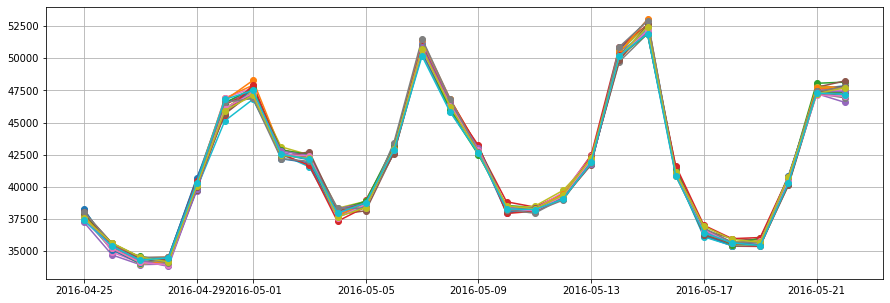

In [34]:
# visualizing the predictions over the validation period
plt.figure(figsize=(15,5))
for i,fcaster in enumerate(all_models):
    _forecast = fcaster.predict(valid_dataframe)    
    plt.plot_date(_forecast.ds, _forecast.y_pred, "o-", label=f"seed: {i}")
plt.grid()
plt.show()

In [38]:
all_forecasts = list()
for fcaster in all_models:
    _forecast = fcaster.predict(pd.concat([valid_dataframe, eval_dataframe], ignore_index=True))
    all_forecasts.append(_forecast)
    
forecast = all_forecasts[0].copy(deep=True)
forecast["y_pred"] = np.mean([_forecast.y_pred for _forecast in all_forecasts], axis=0)

In [39]:
forecast.to_csv("../output/forecast_level1.csv", index=False)

***